<a href="https://colab.research.google.com/github/anshumandec94/Image-Style-Transfer/blob/master/Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install webp

  Created wheel for webp: filename=webp-0.1.0a13-cp36-cp36m-linux_x86_64.whl size=418611 sha256=6d85bf65d0a6b193bdf57e4af3884452e337b0c3f5e3abf9f9bf35a8d7efd0b7
  Stored in directory: /root/.cache/pip/wheels/01/39/d5/fdeb293445c4d6f1c8cd1da47c285c7c643d399a0aaae410ec
Successfully built webp


In [0]:
%pip install Pillow

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import applications
from keras import backend as K
import os
import sys
import PIL
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import webp
import time
import imageio
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline
plt.ioff()

In [0]:
style_path="/content/drive/My Drive/Style Transfer Style Images"
content_path="/content/drive/My Drive/Content Images"
generated_path="drive/My Drive/Generated Images"
img_height, img_width=512, 512

In [0]:
style_img = Image.open(style_path+'/3.jpeg')

In [0]:
style_img=style_img.resize((img_width, img_height), Image.ANTIALIAS)

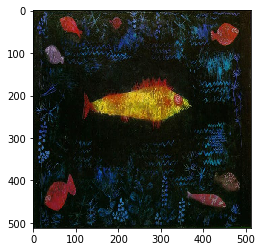

In [8]:
imshow(style_img)
plt.show()


In [0]:
content_img=Image.open(content_path+'/2.jpg')

In [0]:
content_img=content_img.resize((img_width, img_height), Image.ANTIALIAS)

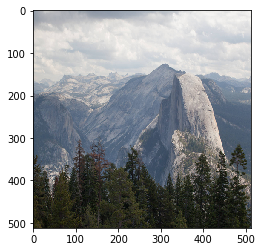

In [11]:
plt.imshow(content_img)
plt.show()

We're now going to decide on some of the layers of VGG19 that we would be using for the purposes of extracting the style and content from our images and applying our loss function combining the two images and our generated image to arrive at a image that incorporates both

In [0]:
def preprocess(img):
  '''
  This function inputs an image, reshape's it to fit the input layer of the VGG19 network, and passes it throught to the preprocessing function of the vgg19 network. 
  The function call is to normalize the inputs of the image as well. 
  '''
  img = img_to_array(img)
  
    # print(img.shape);exit()
  img = np.reshape(img, (img_height, img_width, 3))
  img = img.astype('float64')
  img = np.expand_dims(img, axis=0)
  img = applications.vgg19.preprocess_input(img)
  return img
  

In [0]:
def deprocess_image(img):
    '''
    This function essentially reverses the changes made to the image by the preprocess_input function of the vgg19 network. 
    It also wroks to reshape the image to the specififed height and width. 
    '''
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_height, img_width))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_height, img_width, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [0]:
content_img=K.variable(preprocess(content_img))
style_img=K.variable(preprocess(style_img))


In [16]:
gen_img=K.placeholder(shape=(1,img_height, img_width, 3))# we create a placeholder for the generated image that we will be using.

In [0]:
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)# for our functions and our model,  we generate this input tensor that contains the three images we are 
                                                                       # working with. 

In [18]:
model=applications.vgg19.VGG19(include_top=False, weights="imagenet", input_tensor=input_tensor)# loading our pre-trained weights





80142336/80134624 [==============================] - 5s 0us/step




In [21]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
for layer in model.layers: # we are ensuring that the weights of the pre-trained model are unchanged. 
  layer.trainable= False
  

In [0]:
content_layer='block4_conv3' . # we choose one layer for the content loss, and combine the activations of 5 layers for the style loss. 

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers]) # this dictionary holds the activations generated at each layer.

In [0]:
def content_loss(content, gen): #functioon to generate content loss
  return K.sum(K.square(content-gen))

In [0]:
J_total = 0
content_layer_features=outputs_dict[content_layer]
content_img_features=content_layer_features[0,:,:,:]
generated_img_features=content_layer_features[2,:,:,:]
J_content = content_loss(content_img_features, generated_img_features)#applying the content loss function on the generated and content image.  

In [0]:
def gram_matrix(x):   #gram matrix function for calculating the style loss. This is because we want the two images to share similar style, which is done by looking at the correlation
  assert K.ndim(x) == 3 #between the various activations generated by our style and content image.
  features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [0]:
def style_loss(style, gen): # calculating the style loss for each layer betwee the two images.
  assert K.ndim(style) == 3
  assert K.ndim(gen) == 3
  S = gram_matrix(style)
  G = gram_matrix(gen)
  channels =3
  size = img_width*img_height
  return K.sum(K.square(S-G))/(4. * (channels ** 2) * (size ** 2))

In [0]:
J_style=0 # we concatenate the loss calculated over each layer by the corresponding weights associated to each layer
for name, style_weights in STYLE_LAYERS:
  style_layer_features= outputs_dict[name]
  style_features = style_layer_features[1, :, :, :]
  gen_img_features = style_layer_features[2, :, :, :]
  J_style+=style_weights*(style_loss(style_features, gen_img_features))

In [0]:
def total_variation_loss(x): # this loss is to ensure that the resulting images are less noisy.
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
J_tv=total_variation_loss(gen_img)


In [0]:
alpha = 0.01
beta = 1
loss = (alpha*J_content) + (beta*J_style) + (1*J_tv)# adding up all the losses for our generated image. 

In [33]:
grads = K.gradients(loss, gen_img)

outputs = [loss]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# we create a function to evaluate the loss and the gradients. This is done by creating a backend function that inputs the generated image, calculates the two outputs and
# returns them
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# Define a Keras function
f_output = K.function([gen_img], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_height, img_width))
    else:
        x = x.reshape((1, img_height, img_width, 3))
    # Update the loss and the gradients
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values


evaluator = Evaluator()


In [0]:
x=Image.open(content_path+'/2.jpg')
x=x.resize((img_width, img_height), Image.ANTIALIAS)
x=preprocess(x)# we use x as our generated image, which we set as the content image. This allows for the model to converge quicker than if we used a random noise image. 

In [36]:
for i in range(5):
    print('Step {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads,maxiter=200)# using the L_BFGS optimizing algorithm to generate desired image. 
    print('    loss: {}'.format(min_val))
    # Save img
   
    img = deprocess_image(x)
    imageio.imwrite(generated_path+'/img{}c2s1.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))

Step 0
    loss: 1208284672.0
     Image saved. Time: 88.13597011566162
Step 1
    loss: 1325725568.0
     Image saved. Time: 81.18137168884277
Step 2
    loss: 1401168640.0
     Image saved. Time: 81.86822271347046
Step 3
    loss: 1460802304.0
     Image saved. Time: 81.90696501731873
Step 4
    loss: 1514907520.0
     Image saved. Time: 82.54334592819214


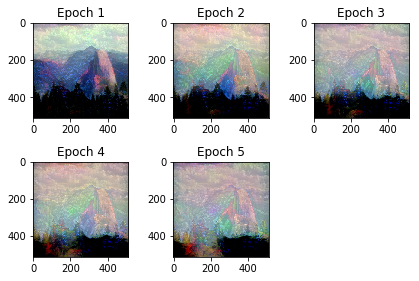

In [40]:
fig=plt.figure()# plotting the generated image by the epochs of our optimizer.

for i in range(5):
  img=Image.open(generated_path+'/img{}c2s1.jpg'.format(i))
  
  ax=fig.add_subplot(2,3,i+1)
  ax.imshow(img)
  ax.title.set_text("Epoch {}".format(i+1))
fig=plt.tight_layout()

plt.show()